**Домашнее задание:**

Вам необходимо определить дисперсию случайной величины ${\displaystyle X = \sum _{i=1}^{n}X_{i}\sim \operatorname {B} (n,p)}$, где ${X_i = 1}$ с вероятностью $p$ и $0$ - с вероятностью $1-p$, причем ${\displaystyle \text{corr}(X_i, X_j)=\text{R} \ \forall \ i \neq j}$.
Для этого подготовьте код в питоне с генетическим" (подстраивающимся) алгоритмом генерации вектора ${\displaystyle (X_1, X_2 \dots X_n)}$ с общим числом реализаций $m$. Соответственно, число единиц в каждом столбце должно быть целочисленным и равно $k = p \cdot m$.

Возможная идея алгоритма:
1. случайно выбирается столбец и две строки в векторе ${\displaystyle (X_1, X_2 \dots X_n)}$ 
2. значения на пересечении выбранных строк и столбца меняются местами
3. если замена значений приближает корреляционную матрицу к целевой, замену сохраняем. Иначе - пробуем иную. 
Под целевой корреляционной матрицей понимаем такую, где все элементы равны R, кроме главной диагонали.

Алгоритм должен работать при любых комбинациях - **p, R, n, m**. 
Работать - значит, запускаться без изменения иных параметров, кроме четырех указанных. При этом работать - не означает сходиться, т.к. определенная комбинация **p, R, n** может быть недостижима.

Для проверки дополнительно сообщу Вам набор параметров - **p, R, n, m**, для которых необходимо вместе с кодом указать величину $\text{Var}(X)$.

**Параметры для задания:**
- **p** = 4 %
- **R** = 1 %
- **n** = 100
- **m** = 200

**Комментарии по вопросам:**
1. да, набор параметров один для всех.
2. загружайте файл ipynb с запущенными командами (т.е. в блокноте виден результат их выполнения), в конце кода ожидаю увидеть два элемента:
- график плотности (гистограмму) распределения ${\displaystyle X = \sum {X_i}}$ для подобранной матрицы.
- оценку дисперсии полученного ${\displaystyle X = \sum {X_i}}$
Если при разработке кода Вы поняли, что на отдельных развилках нужно использовать одно, а не другое,
перечислите такие решения в первых строках кода. 
    - Например: \# 1. сравнение матриц через максимальную разницу не работает, поэтому заложено сравнение всех элементов через меру ${\displaystyle \rm {MAE/RMSE/}}$(иное?)
3. критерий приемки:
в файле есть код, есть график и оценка дисперсии.
открываю файл, могу поменять параметры (из четырех), запускаю; если считается и выдает ожидаемый результат, зачет.
дифференциацию по баллам планирую сделать по тому, насколько оптимальна/интересна логика алгоритма.
4. Да, можно использовать стандартные функции (сумма, среднее, корреляция).
Расписывать их расчет через формулы не требуется.


## **Importing packages, preparing data**

In [1]:
import pandas as pd
import numpy as np
from numpy.random import randint
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style({"font.family": "serif"})

Initialize the input parameters

In [2]:
p = 0.04
R = 0.01
n = 100
m = 200

**Target correlation matrix** with **```1```** on main diagonal and **```R```** in other cells

In [3]:
target_corr_matrix = np.full((n, n), R)
np.fill_diagonal(target_corr_matrix, 1)
target_corr_matrix

array([[1.  , 0.01, 0.01, ..., 0.01, 0.01, 0.01],
       [0.01, 1.  , 0.01, ..., 0.01, 0.01, 0.01],
       [0.01, 0.01, 1.  , ..., 0.01, 0.01, 0.01],
       ...,
       [0.01, 0.01, 0.01, ..., 1.  , 0.01, 0.01],
       [0.01, 0.01, 0.01, ..., 0.01, 1.  , 0.01],
       [0.01, 0.01, 0.01, ..., 0.01, 0.01, 1.  ]])

Matrix with random variables in columns. 

* ${\displaystyle (X_1, X_2...X_n)}$
* shape = (m, n)

In [4]:
k = int(p * m) # ones rows size
ones = np.ones(n * k, dtype=np.int32).reshape((k, n))
zeros = np.zeros(n * (m - k), dtype=np.int32).reshape((m - k, n))
assert ones.shape == (k, n) and zeros.shape == (m - k, n)

X = np.vstack((ones, zeros))
assert X.shape == (m, n)

## **Running tests on our data: genetic algorithm**

**RMSE** - loss function

In [5]:
def rmse(X_true: np.ndarray, X: np.ndarray) -> float:
    # Each row of X represents a variable, 
    # and each column a single observation of all those variables
    corr_matrix = np.corrcoef(X, rowvar=False)
    target_corrs_flat = []
    corrs_flat = []
    for i in range(X.shape[0]):
        for j in range (i + 1, X.shape[1]):
            target_corrs_flat.append(target_corr_matrix[i][j])
            corrs_flat.append(corr_matrix[i][j])

    return np.sqrt(mean_squared_error(target_corrs_flat, corrs_flat))

In [6]:
print("RMSE before applying the genetic algorithm:", rmse(target_corr_matrix, X))

RMSE before applying the genetic algorithm: 0.9900000000000001


**Run the genetic algorithm**

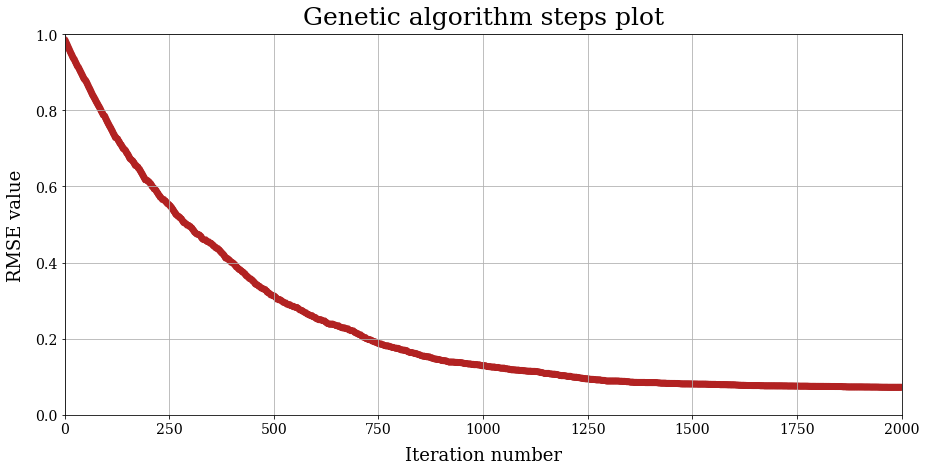

In [7]:
from IPython.display import clear_output

class LoggingCallback:
    """
    Класс для логирования шагов генетического алгоритма. 
    Сохраняет точку (iter_cnt, loss) на каждом шаге.
    Пример использования в коде: callback(iter_cnt, loss)
    """
    def __init__(self):
        self.iter_steps = []
        self.loss_steps = []

    def __call__(self, iter, loss):
        self.iter_steps.append(iter)
        self.loss_steps.append(loss)


def swap(X, col_idx: int, row_idx_1: int, row_idx_2: int) -> None:
    X[row_idx_1][col_idx], X[row_idx_2][col_idx] = (
        X[row_idx_2][col_idx],
        X[row_idx_1][col_idx],
    )


callback = LoggingCallback() 

loss_val = rmse(target_corr_matrix, X)
tol = 1e-5 # минимальное отклонение, при котором итерации продолжаются 
maxiter = 2000 # максимальное допустимое число итераций
iter_cnt = 0 # номер текущей итерации
while loss_val > tol and iter_cnt < maxiter:

    col_idx = randint(n)
    row_idx_1 = randint(0, k)
    row_idx_2 = randint(k, m)
    while row_idx_1 == row_idx_2:
        row_idx_1 = randint(0, k)
        row_idx_2 = randint(k, m)

    # To get corr_matrix similar to true correlation matrix,
    # we need to minimize the loss function
    swap(X, col_idx, row_idx_1, row_idx_2)
    new_loss = rmse(target_corr_matrix, X)
    if new_loss < loss_val:
        loss_val = new_loss
    else:
        swap(X, col_idx, row_idx_1, row_idx_2)

    callback(iter_cnt, loss_val) # Не забываем про логирование

    iter_cnt += 1

    # the rest of code is just bells and whistles
    if (iter_cnt) % 100 == 0:
        clear_output(True)
        fig = plt.figure(figsize=(15, 7), facecolor='w', edgecolor='k')

        plt.scatter(x=callback.iter_steps, 
                    y=callback.loss_steps, 
                    color='firebrick', alpha=0.7, linestyle="-.")
        # Decorations
        plt.title("Genetic algorithm steps plot", fontsize=25, pad=10)
        plt.xlim((0, iter_cnt)); plt.ylim((0, 1))
        plt.xlabel("Iteration number", fontsize=18, labelpad=10)
        plt.ylabel("RMSE value", fontsize=18, labelpad=10)
        plt.xticks(fontsize=14); plt.yticks(fontsize=14)
        plt.grid()
        plt.show()

Let's look at the resulting correlation matrix of random variables after applying the genetic algorithm

In [8]:
target_corr_matrix

array([[1.  , 0.01, 0.01, ..., 0.01, 0.01, 0.01],
       [0.01, 1.  , 0.01, ..., 0.01, 0.01, 0.01],
       [0.01, 0.01, 1.  , ..., 0.01, 0.01, 0.01],
       ...,
       [0.01, 0.01, 0.01, ..., 1.  , 0.01, 0.01],
       [0.01, 0.01, 0.01, ..., 0.01, 1.  , 0.01],
       [0.01, 0.01, 0.01, ..., 0.01, 0.01, 1.  ]])

In [9]:
np.corrcoef(X, rowvar=False)

array([[ 1.        ,  0.08854167, -0.04166667, ..., -0.04166667,
        -0.04166667,  0.21875   ],
       [ 0.08854167,  1.        ,  0.08854167, ..., -0.04166667,
        -0.04166667, -0.04166667],
       [-0.04166667,  0.08854167,  1.        , ...,  0.08854167,
         0.08854167, -0.04166667],
       ...,
       [-0.04166667, -0.04166667,  0.08854167, ...,  1.        ,
         0.08854167, -0.04166667],
       [-0.04166667, -0.04166667,  0.08854167, ...,  0.08854167,
         1.        ,  0.21875   ],
       [ 0.21875   , -0.04166667, -0.04166667, ..., -0.04166667,
         0.21875   ,  1.        ]])

## **Visualizing results**

${\displaystyle X = \sum _{i=1}^{n}X_{i}\sim \operatorname {B} (n,p)}, \text{where} \\ X_i={\begin{cases}1&p,\\0&q-p.\end{cases}}$

In [10]:
X_result = X.sum(axis=1)

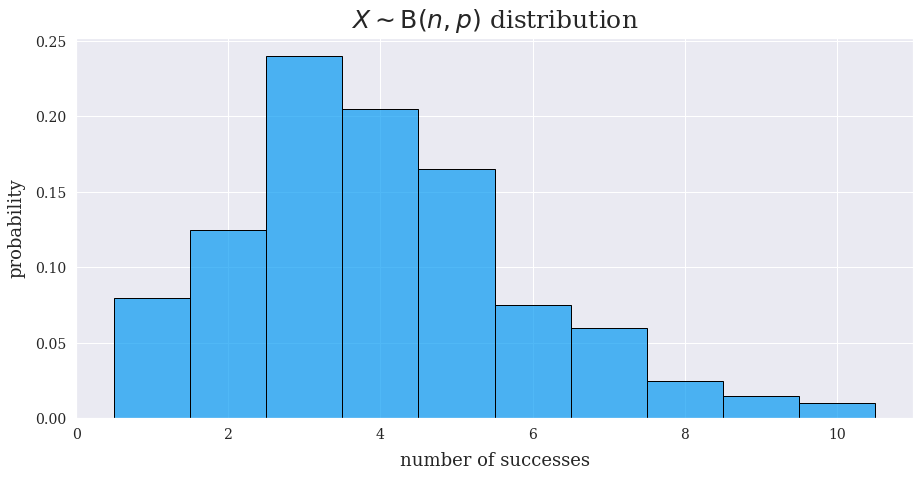

In [16]:
sns.set(style="darkgrid", font_scale=1.3)
sns.set_style({"font.family": "serif"})
fig = plt.figure(figsize=(15,7))
plt.title(r"$X \sim \operatorname {B} (n,p)$ distribution", fontsize = 25, pad=10)
plt.xlabel("number of successes", fontsize=18, labelpad=10)
plt.ylabel('probability', fontsize=18, labelpad=10)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
sns.histplot(data=X_result, stat="proportion", discrete=True, 
                alpha=0.7, 
                color="xkcd:azure", 
                edgecolor="black")
plt.show()

In [14]:
np.var(X_result)

4.57